# Logistic regression and Naive Bayes (on clean dataset)

### Start by balancing the datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from fancyimpute import KNN 
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.impute import KNNImputer
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.impute import KNNImputer

Using TensorFlow backend.


In [2]:
df = pd.read_csv('C:\\...\\dataset.csv')

In [42]:
#drop the NaN in my outcome variable, leave the rest as the model should ignore them
df = df[pd.notnull(df['GESTATIONAL_AGE_CAT'])]

In [43]:
#check the number of Nans in the df
df.isnull().sum()

Unnamed: 0                0
ANEMIA                   42
ASTHMA                 2562
BMI_CAT                 980
CIG_NOW                  10
DIABETES                 34
GESTATIONAL_AGE           0
GESTATIONAL_AGE_CAT       0
HIGHBP_NOTPREG            4
HIGHBP_PREECLAMPSIA      32
KIDNEY                   30
MOM_INSURANCE           117
MOM_PIDX                  0
VAGINOSIS                28
dtype: int64

In [44]:
#since the model later will not be happy with MOM_PIDX, lets drop it now
df1 = df.drop(['Unnamed: 0','MOM_PIDX','GESTATIONAL_AGE'], axis=1)

In [45]:
df1

,ANEMIA,ASTHMA,BMI_CAT,CIG_NOW,DIABETES,GESTATIONAL_AGE_CAT,HIGHBP_NOTPREG,HIGHBP_PREECLAMPSIA,KIDNEY,MOM_INSURANCE,VAGINOSIS
0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
7863,1.0,NaN,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7864,0.0,NaN,6.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7865,0.0,NaN,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7866,0.0,NaN,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


#### Downsampling to balance my classes

In [46]:
#before downsampling, I must split my data in training and testing sets
y = df1.GESTATIONAL_AGE_CAT
X = df1.drop('GESTATIONAL_AGE_CAT', axis=1) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

In [47]:
# concatenate our training data back together
B = pd.concat([X_train, y_train], axis=1)

In [48]:
# separate minority and majority classes
nopreterm = B[B.GESTATIONAL_AGE_CAT==0]
preterm = B[B.GESTATIONAL_AGE_CAT==1]

In [49]:
# downsample majority
nopreterm_downsampled = resample(nopreterm,
                                replace = False, # sample without replacement
                                n_samples = len(preterm), # match minority n
                                random_state = 27) # reproducible results

In [50]:
# combine minority and downsampled majority
df_down = pd.concat([nopreterm_downsampled, preterm])

In [51]:
# checking counts
df_down.GESTATIONAL_AGE_CAT.value_counts()

1.0    1062
0.0    1062
Name: GESTATIONAL_AGE_CAT, dtype: int64

#### Perform a KNN to impute the missing data

In [52]:
imputer = KNNImputer(n_neighbors=9)

In [53]:
df_filled = imputer.fit_transform(df_down)

In [54]:
df_filled = pd.DataFrame(df_filled, 
                        columns=df_down.columns)

In [55]:
df_filled= df_filled.drop('BMI_CAT', axis = 1)

### Perform the logistic Regression

In [56]:
y = df_filled.GESTATIONAL_AGE_CAT
X = df_filled.drop('GESTATIONAL_AGE_CAT', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

In [57]:
#use recursive feature elimination to see if any of the variables are not needed in the model:
logreg = LogisticRegression()

In [58]:
rfe = RFE(logreg, 20)

In [59]:
rfe = rfe.fit(X, y.values.ravel())

In [60]:
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1]


 So far all the features appear to be contributing to the model. Next I will fit the logistic regression

In [61]:
#apply the model
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.675141
         Iterations 5
                            Logit Regression Results                           
Dep. Variable:     GESTATIONAL_AGE_CAT   No. Observations:                 2124
Model:                           Logit   Df Residuals:                     2115
Method:                            MLE   Df Model:                            8
Date:                 Fri, 07 Feb 2020   Pseudo R-squ.:                 0.02598
Time:                         16:42:03   Log-Likelihood:                -1434.0
converged:                        True   LL-Null:                       -1472.2
Covariance Type:             nonrobust   LLR p-value:                 2.480e-13
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
ANEMIA                  0.2239      0.120      1.868      0.062      -0.011       

In [62]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [63]:
y_pred = logreg.predict(X_test)

In [64]:
print('Accuracy score: ', accuracy_score(y_test, y_pred.round()))
print('Precision score: ', precision_score(y_test, y_pred.round()))
print('Recall score: ', recall_score(y_test, y_pred.round()))

Accuracy score:  0.5649717514124294
Precision score:  0.5590909090909091
Recall score:  0.4785992217898833


In [68]:
## logit option 2, (intercept):
#model=smf.logit("GESTATIONAL_AGE_CAT ~ ANEMIA + ASTHMA + CIG_NOW + HIGHBP_PREECLAMPSIA + HIGHBP_NOTPREG + KIDNEY + MOM_INSURANCE +VAGINOSIS", data=df_filled)
#result =model.fit()
#print(result.summary())

### Perform the Native Bayes

In [69]:
y = df_filled.GESTATIONAL_AGE_CAT
X = df_filled.drop('GESTATIONAL_AGE_CAT', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

In [70]:
naive_bayes = MultinomialNB()

In [71]:
naive_bayes.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [72]:
y_pred = naive_bayes.predict(X_test)

In [73]:
print('Accuracy score: ', accuracy_score(y_test, y_pred.round()))
print('Precision score: ', precision_score(y_test, y_pred.round()))
print('Recall score: ', recall_score(y_test, y_pred.round()))

Accuracy score:  0.5781544256120528
Precision score:  0.5708154506437768
Recall score:  0.5175097276264592


## Make a roc curve of all three models to compare

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

In [75]:
plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
{
    'label': 'Naive Bayes',
    'model': MultinomialNB(),
},
{
    'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
}
]

<Figure size 432x288 with 0 Axes>

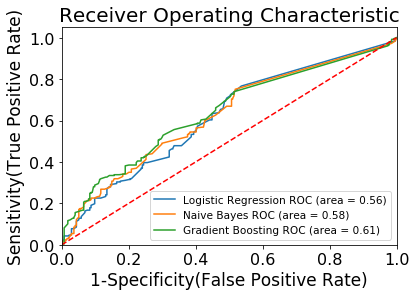

In [76]:
# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)',fontsize=17)
plt.ylabel('Sensitivity(True Positive Rate)',fontsize=17)
plt.title('Receiver Operating Characteristic',fontsize=20)
plt.legend(loc="lower right", fontsize=10.5)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.savefig('all_ROC')
plt.show()   # Display

Even after balacing the dataset and imputing the missing data, Naive Bayes and Logistic regression did not perfom at the same level of the gradient boosting RF. I will fit a lightGBM to predict preterm labors.